In [16]:
import os
import pickle
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.collections as cl
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
def reverse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 
    bases = list(seq) 
    # check if the input sequence is actually DNA
    # If there is any letter ather than ATCG, this function will alert an error 
    for base in bases:
        if base not in complement.keys():
            print "not DNA"  
    # actual reverse complement processes 
    complement_bases = [complement[base] for base in bases] 
    complement_seq = ''.join(complement_bases)
    reverse_complement_seq = complement_seq[::-1] # possible to do this on list as well by reversed(list)  
    return reverse_complement_seq# Change DNA to RNA

def gff_plus_strand(gff_file):   
    # a function to get the sequence of E coli genome from GFF file
    # output is string
    with open(gff_file) as fh:
        plus_strand = ''
        flag = 0
        for line in fh:
            if line[0] == ">":
                flag = 1
                continue
            if flag == 0:
                continue
            plus_strand = plus_strand + line[:-1]
    return plus_strand 

In [7]:
gff_file = 'coli.gff'
plus_strand_sequence = gff_plus_strand(gff_file)

In [ ]:
outputfile2 = '/home/kazuki/^data_analysis/^Ecoli_Genome/Positions_ATG_InRNA.csv'
Positions_DataFrame = pd.read_csv(outputfile2)
Positions_DataFrame = Positions_DataFrame.loc[:,~Positions_DataFrame.columns.str.contains('^Unnamed')]

Start = Positions_DataFrame['At_start'].notnull()
notStart = Positions_DataFrame['At_start'].isnull()

inRNA = Positions_DataFrame['In_RNA']=='yes'
not_inRNA = Positions_DataFrame['In_RNA'].isnull()

strong_at_CCUCC = Positions_DataFrame['Vs_uCCUCCa'] <= -4
Not_strong_at_CCUCC = Positions_DataFrame['Vs_uCCUCCa'] > -4
weak_at_CCUCC = Positions_DataFrame['Vs_uCCUCCa'] > 0



strong_at_AGGGU = Positions_DataFrame['Vs_uAGGGUa'] <= -4
Not_strong_at_AGGGU = Positions_DataFrame['Vs_uAGGGUa'] > -4
strong_at_GGAGG = Positions_DataFrame['Vs_uGGAGGa'] <= -4
Not_strong_at_GGAGG = Positions_DataFrame['Vs_uGGAGGa'] > -4
strong_at_AAAAA = Positions_DataFrame['Vs_uAAAAAa'] <= -4
Not_strong_at_AAAAA = Positions_DataFrame['Vs_uAAAAAa'] > -4

In [14]:
down_for_fasta = 30
up_for_fasta = 30

In [21]:
if not os.path.exists('kpLogo'):
    os.makedirs('kpLogo')
if not os.path.exists('kpLogo/fasta'):
    os.makedirs('kpLogo/fasta')
if not os.path.exists('kpLogo/results'):
    os.makedirs('kpLogo/results')

# Annotated with weakSD VS Non-annotated

In [22]:
df_to_use = Positions_DataFrame[Start & inRNA & weak_at_CCUCC]
fasta = 'kpLogo/fasta/Start_weakSD.fasta'

with open(fasta, 'w') as f_o:
    for index in df_to_use.index:
        if df_to_use.loc[index,'strand'] == '+':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-down_for_fasta-1
            end = ATG+up_for_fasta-1
            seq = plus_strand_sequence[start:end]
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')
        if df_to_use.loc[index,'strand'] == '-':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-up_for_fasta
            end = ATG+down_for_fasta
            r_seq = plus_strand_sequence[start:end]
            seq = reverse_complement(r_seq)
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')      

In [23]:
df_to_use = Positions_DataFrame[notStart & inRNA]
fasta = 'kpLogo/fasta/Nonstart.fasta'

with open(fasta, 'w') as f_o:
    for index in df_to_use.index:
        if df_to_use.loc[index,'strand'] == '+':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-down_for_fasta-1
            end = ATG+up_for_fasta-1
            seq = plus_strand_sequence[start:end]
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')
        if df_to_use.loc[index,'strand'] == '-':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-up_for_fasta
            end = ATG+down_for_fasta
            r_seq = plus_strand_sequence[start:end]
            seq = reverse_complement(r_seq)
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')      

In [24]:
kpLogo = '^tools/kpLogo-1.1/bin/kpLogo'

positive = 'kpLogo/fasta/Start_weakSD.fasta'
background = 'kpLogo/fasta/Nonstart.fasta'
output = 'kpLogo/results/annoVSnonanno'

import os
command = '%s %s -bgfile %s -o %s' % (
    kpLogo,
    positive,
    background,
    output
    )
print command
os.system(command)

^tools/kpLogo-1.1/bin/kpLogo kpLogo/fasta/Start_weakSD.fasta -bgfile kpLogo/fasta/Nonstart.fasta -o kpLogo/results/annoVSnonanno


0

In [31]:
from IPython.display import IFrame
IFrame(output+'.pdf', width=1000, height=300)

In [4]:
def RCRPM_loading(RC,RPM,filename,endtype,densitypath):
    with open(densitypath+filename+endtype+'_readcounts.pickle', 'rb') as f:
        RC[filename]=pickle.load(f)
    with open(densitypath+filename+endtype+'_rpm.pickle', 'rb') as f:
        RPM[filename]=pickle.load(f)
    #return [rcs,rpms]

In [5]:
import multiprocessing
import pickle
import threading
from datetime import datetime

print datetime.now()

#RC ={} somehow I need to do below to assign this dict to get the value evalutated from the RCRPM_loading
#RPM = {} somehow I need to do below to assign this dict to get the value evalutated from the RCRPM_loading
manager = multiprocessing.Manager()
RC = manager.dict()
RPM = manager.dict()

jobs = []

filenames = ['ks110ks83','ks117ks92']
endtype = '_3map'
densitypath = '/home/kazuki/^profilingdata/20181017_MS2/density/'
for filename in filenames:
    job = multiprocessing.Process(target=RCRPM_loading, args=(RC,RPM,filename,endtype,densitypath))
    jobs.append(job)
    job.start()

filenames = ['ks120','ks121','ks122','ks123']
endtype = '_3map'
densitypath = '/home/kazuki/^profilingdata/20181207_MS2/density_tkEIGHT/'
for filename in filenames:
    job = multiprocessing.Process(target=RCRPM_loading, args=(RC,RPM,filename,endtype,densitypath))
    jobs.append(job)
    job.start()

filenames = ['ks130']
endtype = '_3map'
densitypath = '/home/kazuki/^profilingdata/20181207_MS2/density/'
for filename in filenames:
    job = multiprocessing.Process(target=RCRPM_loading, args=(RC,RPM,filename,endtype,densitypath))
    jobs.append(job)
    job.start()
    
    
filenames = ['ks170','ks171','ks172']
endtype = '_3map'
densitypath = '/home/kazuki/^profilingdata/20190503/density/'
for filename in filenames:
    job = multiprocessing.Process(target=RCRPM_loading, args=(RC,RPM,filename,endtype,densitypath))
    jobs.append(job)
    job.start()      
    
    
[job.join() for job in jobs] # just to get the time by the below line

print datetime.now() 

2019-05-14 11:47:01.853711
2019-05-14 11:47:30.544949


In [8]:
def threshold(cut_off,readcountsf_plus, position, upstream_length,downstream_length):
    if sum(readcountsf_plus[position-upstream_length:position+downstream_length])>=cut_off:
        return 'yes'
    else:
        return 'no'
    
def peak_ratio(cut_off,readcounts,positions,upstream_length,downstream_length,peak_upstream,peak_downstream):
    peaks = {}
    peaks['+']={}
    peaks['-']={}
    
    total_plus = 0
    readcounts_plus = readcounts[0][readcounts[0].keys()[0]]
    #rpm_plus = rpm[0][rpm[0].keys()[0]]
    position_plus = positions['+']
    for position in position_plus:
        cut_off_result = threshold(cut_off,readcounts_plus,position,upstream_length,downstream_length)
        if cut_off_result == 'yes':  
            total_read = sum(readcounts_plus[position-upstream_length-1:position+downstream_length-1])
            peak_read = sum(readcounts_plus[position-peak_upstream-1:position+peak_downstream-1])
            if total_read!=0 and peak_read!=0:
                total_plus+=1
                total_average = float(total_read)/len(readcounts_plus[position-upstream_length-1:position+downstream_length-1])
                peak_average = float(peak_read)/len(readcounts_plus[position-peak_upstream-1:position+peak_downstream-1])
                if total_average !=0:
                    peak_ratio = float(peak_average)/total_average
                    if peak_ratio != 0:
                        peaks['+'][position]=peak_ratio
            
    total_minus = 0
    readcounts_minus = readcounts[1][readcounts[1].keys()[0]]
    #rpm_minus = rpm[1][rpm[1].keys()[0]]
    position_minus = positions['-']
    for position in position_minus:
        cut_off_result = threshold(cut_off,readcounts_minus,position,downstream_length,upstream_length)# opposite as minus       
        if cut_off_result == 'yes':   
            total_read = sum(readcounts_minus[position-downstream_length:position+upstream_length])
            peak_read = sum(readcounts_minus[position-peak_downstream:position+peak_upstream])
            if total_read!=0:
                total_minus+=1
                total_average = float(total_read)/len(readcounts_minus[position-downstream_length:position+upstream_length])
                peak_average = float(peak_read)/len(readcounts_minus[position-peak_downstream:position+peak_upstream])
                if total_average !=0:
                    peak_ratio = float(peak_average)/total_average
                    if peak_ratio != 0:
                        peaks['-'][position]=peak_ratio

    return peaks


def get_position_dict(df):
    df.reset_index(inplace=True)
    position_dict = {}
    position_dict['+']=[]
    position_dict['-']=[]
    for i in range(len(df)):
        if df.loc[i,'strand'] == '+':
            position_dict['+'].append(df.loc[i,'ATG'])
        if df.loc[i,'strand'] == '-':
            position_dict['-'].append(df.loc[i,'ATG'])
    return position_dict


def get_log2PeakScore(peaks):
    FD=[]
    for strand in peaks.keys():
        FD = FD + peaks[strand].values()
    print len(FD)
    return np.log2(FD)



# Actual analysis of libraries

In [9]:
def distribution_plotter(ax_here,data,palette,Violin_BoxSwarm):
    if Violin_BoxSwarm == 0:
        ax = sns.violinplot(data=data,
                            palette=palette,
                            linewidth=1,
                            inner=None,
                            oxprops = {'edgecolor': 'black'},
                            whiskerprops={'color': 'black'},
                            ax=ax_here)        
    
    if Violin_BoxSwarm == 1:
        ax = sns.boxplot(data=data,
                         showfliers=False,
                         linewidth=3,
                         palette=palette,
                         capprops={'color': 'black', 'linewidth': 3},
                         medianprops = {'color': 'black', 'linewidth': 3}, 
                         boxprops = {'edgecolor': 'black', 'linewidth': 3, 'facecolor': 'none',"zorder":10},
                         whiskerprops={'color': 'black','linewidth':1, "zorder":10},
                         ax=ax_here)
        ax = sns.swarmplot(data=data,
                           palette=palette,
                           zorder=.5,
                           alpha=0.8,
                           ax=ax_here)
        
        
    if Violin_BoxSwarm == 2:
        ax = sns.violinplot(data=data,
                            palette=palette,
                            linewidth=2.5,
                            facebolor = 'none',
                            ax=ax_here)
        ax = sns.swarmplot(data=data,
                           palette=palette,
                           zorder=.5,
                           alpha=0.8,
                           ax=ax_here)   
        

In [10]:
threshold_setting = 10

distance = 50
upstream_length_setting = distance
downstream_length_setting = distance

peak_upstream = -3
peak_downstream = 21

# NON-start

In [11]:
df1 = Positions_DataFrame[notStart&inRNA]
df2 = Positions_DataFrame[notStart&inRNA&strong_at_CCUCC]
df3 = Positions_DataFrame[notStart&inRNA&strong_at_AGGGU]
df4 = Positions_DataFrame[notStart&inRNA&strong_at_GGAGG]
df5 = Positions_DataFrame[notStart&inRNA&strong_at_AAAAA]
dfs = [df1,df2,df3,df4]

2892
3773


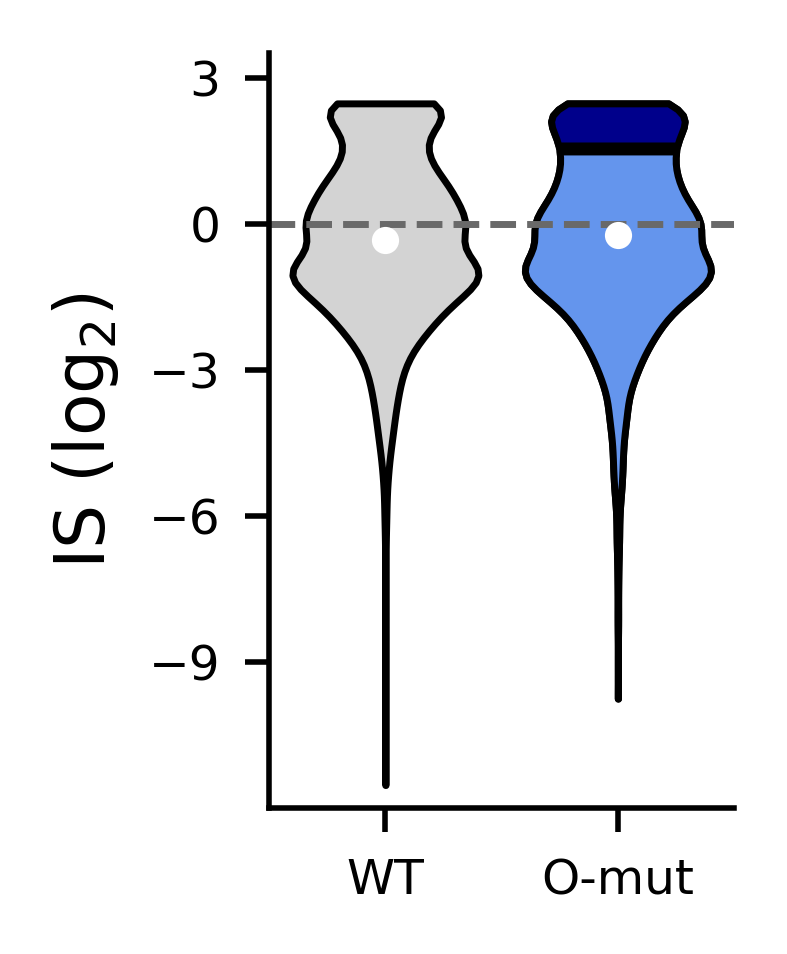

In [12]:
# https://stackoverflow.com/questions/51639481/specify-colors-above-and-below-median-on-violin-plot-in-seaborn-matplotlib
# https://matplotlib.org/gallery/statistics/customized_violin.html

fig, ax = plt.subplots()
fig.set_dpi(500)
fig.set_size_inches(1.2, 2)

df = Positions_DataFrame[notStart&inRNA]
libraries = ['ks170','ks110ks83']

positions = get_position_dict(df)
data = []
median_list = []
for library in libraries:
    peaks=peak_ratio(threshold_setting,RC[library],positions,upstream_length_setting,downstream_length_setting,peak_upstream,peak_downstream)
    FDs=get_log2PeakScore(peaks)
    data.append(FDs)
    median_list.append(np.median(FDs))

result_dict = ax.violinplot(data, showextrema=False, showmedians=False,widths=0.8) 

for pc in result_dict['bodies']:
    pc.set_facecolor('lightgrey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)


orig_violin = result_dict['bodies'][1]  # in this case, there is only one violin plot, hence [0]
orig_vertices = orig_violin.get_paths()[0].vertices # extract the vertices coordinates from the Path object contained in the PolyCollection

top = orig_vertices[orig_vertices[:,1]>=1.5]   # the vertices above the median
bottom = orig_vertices[orig_vertices[:,1]<=1.5] # and below 

# create new PolyCollections, adjusting their appearance as desired
topP = cl.PolyCollection([top])
topP.set_facecolor('darkblue')
topP.set_edgecolor('black')
bottomP = cl.PolyCollection([bottom])
bottomP.set_facecolor('cornflowerblue')
bottomP.set_edgecolor('black')
ax.add_collection(topP)
ax.add_collection(bottomP)

ax = sns.scatterplot(x=[1,2],y=median_list,color='white',zorder=10,s=10)
ax.axhline(y=0,linewidth=1, color='dimgrey',linestyle='--')

sns.despine()
plt.xlim(0.5,2.5)
plt.xticks([1,2],['WT','O-mut'])
plt.ylim(-12,3.5)
plt.yticks([-9,-6,-3,0,3])
plt.ylabel('IS ($\log_2$)')
plt.tick_params(labelsize=7)

#plt.savefig('reta_figure/ret_violin_nonstart_O.pdf', dpi=500, bbox_inches="tight", pad_inches=0.0)

# genes specifically increased on Non-start

In [28]:
def peak_ratio(cut_off,readcounts,positions,upstream_length,downstream_length,peak_upstream,peak_downstream):
    peaks = {}
    peaks['+']={}
    peaks['-']={}
    
    total_plus = 0
    readcounts_plus = readcounts[0][readcounts[0].keys()[0]]
    #rpm_plus = rpm[0][rpm[0].keys()[0]]
    position_plus = positions['+']
    for position in position_plus:
        cut_off_result = threshold(cut_off,readcounts_plus,position,upstream_length,downstream_length)
        if cut_off_result == 'yes':  
            total_read = sum(readcounts_plus[position-upstream_length-1:position+downstream_length-1])
            peak_read = sum(readcounts_plus[position-peak_upstream-1:position+peak_downstream-1])
            if total_read!=0 and peak_read!=0:
                total_plus+=1
                total_average = float(total_read)/len(readcounts_plus[position-upstream_length-1:position+downstream_length-1])
                peak_average = float(peak_read)/len(readcounts_plus[position-peak_upstream-1:position+peak_downstream-1])
                if total_average !=0:
                    peak_ratio = float(peak_average)/total_average
                    if peak_ratio != 0:
                        peaks['+'][position]=peak_ratio
            
    total_minus = 0
    readcounts_minus = readcounts[1][readcounts[1].keys()[0]]
    #rpm_minus = rpm[1][rpm[1].keys()[0]]
    position_minus = positions['-']
    for position in position_minus:
        cut_off_result = threshold(cut_off,readcounts_minus,position,downstream_length,upstream_length)# opposite as minus       
        if cut_off_result == 'yes':   
            total_read = sum(readcounts_minus[position-downstream_length:position+upstream_length])
            peak_read = sum(readcounts_minus[position-peak_downstream:position+peak_upstream])
            if total_read!=0:
                total_minus+=1
                total_average = float(total_read)/len(readcounts_minus[position-downstream_length:position+upstream_length])
                peak_average = float(peak_read)/len(readcounts_minus[position-peak_downstream:position+peak_upstream])
                if total_average !=0:
                    peak_ratio = float(peak_average)/total_average
                    if peak_ratio != 0:
                        peaks['-'][position]=peak_ratio
    """
    print sum(readcounts_plus[:])
    print len(position_plus)
    print total_plus
    print len(peaks['+'])
    print 
    print sum(readcounts_minus[:])
    print len(position_minus)
    print total_minus
    print len(peaks['-'])
    """
    return peaks

In [210]:

distance = 50
PeakScore_threshold = 1.5

threshold_setting = 5
peak_upstream = -3
peak_downstream = 21
upstream_length_setting = distance
downstream_length_setting = distance
graph_upstream = upstream_length_setting-25
graph_downstream = upstream_length_setting+50

########################################################################

#files = ['ks117ks92']
#files = ['ks120','ks121','ks122','ks123']
files = ['ks170','ks110ks83','ks171','ks172']

rcs=[]
for f_n in files:
    rcs.append(RC[f_n])
    
"""
df1 = Positions_DataFrame[notStart&inRNA]
dfs = [df1]


df1 = Positions_DataFrame[notStart&inRNA]
df2 = Positions_DataFrame[notStart&inRNA]
df3 = Positions_DataFrame[notStart&inRNA]
df4 = Positions_DataFrame[notStart&inRNA]
dfs = [df1,df2,df3,df4]
"""

df1 = Positions_DataFrame[notStart&inRNA&strong_at_CCUCC]
df2 = Positions_DataFrame[notStart&inRNA&strong_at_AGGGU]
df3 = Positions_DataFrame[notStart&inRNA&strong_at_GGAGG]
df4 = Positions_DataFrame[notStart&inRNA&strong_at_AAAAA]
dfs = [df1,df2,df3,df4]


high_group={}
for f,rc,df in zip(files,rcs,dfs):
    df.reset_index(inplace=True)
    position_dict = {}
    position_dict['+']=[]
    position_dict['-']=[]
    for i in range(len(df)):
        if df.loc[i,'strand'] == '+':
            position_dict['+'].append(df.loc[i,'ATG'])
        if df.loc[i,'strand'] == '-':
            position_dict['-'].append(df.loc[i,'ATG'])
    positions = position_dict

    ##########
    readcounts = rc
    ##########
    peaks=peak_ratio(threshold_setting,readcounts,positions,upstream_length_setting,downstream_length_setting,peak_upstream,peak_downstream)

    high_group[f]={}
    for strand in peaks.keys():
        high_group[f][strand]={}
        for position in peaks[strand].keys():
            if np.log2(peaks[strand][position]) > PeakScore_threshold:
                high_group[f][strand][position] = peaks[strand][position]


    for key in high_group[f].keys():
        print len(high_group[f][key])
        
        
plus_strand = Positions_DataFrame['strand'] == '+'
minus_strand = Positions_DataFrame['strand'] == '-' 




"""
WT_high_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks117ks92']['+'])
WT_high_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks117ks92']['-'])
WT_normal_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks117ks92']['+']) == False
WT_normal_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks117ks92']['-']) == False





WT_high_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks120']['+'])
WT_high_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks120']['-'])
WT_normal_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks120']['+']) == False
WT_normal_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks120']['-']) == False

O_high_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks121']['+'])
O_high_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks121']['-'])
O_normal_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks121']['+']) == False
O_normal_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks121']['-']) == False

S_high_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks122']['+'])
S_high_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks122']['-'])
S_normal_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks122']['+']) == False
S_normal_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks122']['-']) == False

A_high_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks123']['+'])
A_high_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks123']['-'])
A_normal_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks123']['+']) == False
A_normal_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks123']['-']) == False




WT_high_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks170']['+'])
WT_high_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks170']['-'])
WT_normal_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks170']['+']) == False
WT_normal_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks170']['-']) == False

O_high_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks110ks83']['+'])
O_high_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks110ks83']['-'])
O_normal_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks110ks83']['+']) == False
O_normal_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks110ks83']['-']) == False

S_high_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks171']['+'])
S_high_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks171']['-'])
S_normal_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks171']['+']) == False
S_normal_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks171']['-']) == False

A_high_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks172']['+'])
A_high_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks172']['-'])
A_normal_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks172']['+']) == False
A_normal_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks172']['-']) == False
"""


"""
WT_high_group_plus = Positions_DataFrame[strong_at_CCUCC]['ATG'].isin(high_group['ks120']['+'])
WT_high_group_minus = Positions_DataFrame[strong_at_CCUCC]['ATG'].isin(high_group['ks120']['-'])
WT_normal_group_plus = Positions_DataFrame[strong_at_CCUCC]['ATG'].isin(high_group['ks120']['+']) == False
WT_normal_group_minus = Positions_DataFrame[strong_at_CCUCC]['ATG'].isin(high_group['ks120']['-']) == False

O_high_group_plus = Positions_DataFrame[strong_at_AGGGU]['ATG'].isin(high_group['ks121']['+'])
O_high_group_minus = Positions_DataFrame[strong_at_AGGGU]['ATG'].isin(high_group['ks121']['-'])
O_normal_group_plus = Positions_DataFrame[strong_at_AGGGU]['ATG'].isin(high_group['ks121']['+']) == False
O_normal_group_minus = Positions_DataFrame[strong_at_AGGGU]['ATG'].isin(high_group['ks121']['-']) == False

S_high_group_plus = Positions_DataFrame[strong_at_GGAGG]['ATG'].isin(high_group['ks122']['+'])
S_high_group_minus = Positions_DataFrame[strong_at_GGAGG]['ATG'].isin(high_group['ks122']['-'])
S_normal_group_plus = Positions_DataFrame[strong_at_GGAGG]['ATG'].isin(high_group['ks122']['+']) == False
S_normal_group_minus = Positions_DataFrame[strong_at_GGAGG]['ATG'].isin(high_group['ks122']['-']) == False

A_high_group_plus = Positions_DataFrame[strong_at_AAAAA]['ATG'].isin(high_group['ks123']['+'])
A_high_group_minus = Positions_DataFrame[strong_at_AAAAA]['ATG'].isin(high_group['ks123']['-'])
A_normal_group_plus = Positions_DataFrame[strong_at_AAAAA]['ATG'].isin(high_group['ks123']['+']) == False
A_normal_group_minus = Positions_DataFrame[strong_at_AAAAA]['ATG'].isin(high_group['ks123']['-']) == False
"""



WT_high_group_plus = Positions_DataFrame[strong_at_CCUCC]['ATG'].isin(high_group['ks170']['+'])
WT_high_group_minus = Positions_DataFrame[strong_at_CCUCC]['ATG'].isin(high_group['ks170']['-'])
WT_normal_group_plus = Positions_DataFrame[strong_at_CCUCC]['ATG'].isin(high_group['ks170']['+']) == False
WT_normal_group_minus = Positions_DataFrame[strong_at_CCUCC]['ATG'].isin(high_group['ks170']['-']) == False

O_high_group_plus = Positions_DataFrame[strong_at_AGGGU]['ATG'].isin(high_group['ks110ks83']['+'])
O_high_group_minus = Positions_DataFrame[strong_at_AGGGU]['ATG'].isin(high_group['ks110ks83']['-'])
O_normal_group_plus = Positions_DataFrame[strong_at_AGGGU]['ATG'].isin(high_group['ks110ks83']['+']) == False
O_normal_group_minus = Positions_DataFrame[strong_at_AGGGU]['ATG'].isin(high_group['ks110ks83']['-']) == False

S_high_group_plus = Positions_DataFrame[strong_at_GGAGG]['ATG'].isin(high_group['ks171']['+'])
S_high_group_minus = Positions_DataFrame[strong_at_GGAGG]['ATG'].isin(high_group['ks171']['-'])
S_normal_group_plus = Positions_DataFrame[strong_at_GGAGG]['ATG'].isin(high_group['ks171']['+']) == False
S_normal_group_minus = Positions_DataFrame[strong_at_GGAGG]['ATG'].isin(high_group['ks171']['-']) == False

A_high_group_plus = Positions_DataFrame[strong_at_AAAAA]['ATG'].isin(high_group['ks172']['+'])
A_high_group_minus = Positions_DataFrame[strong_at_AAAAA]['ATG'].isin(high_group['ks172']['-'])
A_normal_group_plus = Positions_DataFrame[strong_at_AAAAA]['ATG'].isin(high_group['ks172']['+']) == False
A_normal_group_minus = Positions_DataFrame[strong_at_AAAAA]['ATG'].isin(high_group['ks172']['-']) == False


59
72
158
202
72
112
0
0


In [116]:
"""
distance = 50
PeakScore_threshold = 1.5
PeakScore_threshold_lower = 0

threshold_setting = 5
peak_upstream = -3
peak_downstream = 21
upstream_length_setting = distance
downstream_length_setting = distance
graph_upstream = upstream_length_setting-25
graph_downstream = upstream_length_setting+50

########################################################################

#files = ['ks120','ks121','ks122','ks123']
files = ['ks170','ks110ks83','ks171','ks172']

rcs=[]
for f_n in files:
    rcs.append(RC[f_n])
    

df1 = Positions_DataFrame[notStart&inRNA&strong_at_CCUCC]
df2 = Positions_DataFrame[notStart&inRNA&strong_at_AGGGU]
df3 = Positions_DataFrame[notStart&inRNA&strong_at_GGAGG]
df4 = Positions_DataFrame[notStart&inRNA&strong_at_AAAAA]
dfs = [df1,df2,df3,df4]

high_group={}
low_group={}
for f,rc,df in zip(files,rcs,dfs):
    df.reset_index(inplace=True)
    position_dict = {}
    position_dict['+']=[]
    position_dict['-']=[]
    for i in range(len(df)):
        if df.loc[i,'strand'] == '+':
            position_dict['+'].append(df.loc[i,'ATG'])
        if df.loc[i,'strand'] == '-':
            position_dict['-'].append(df.loc[i,'ATG'])
    positions = position_dict

    ##########
    readcounts = rc
    ##########
    peaks=peak_ratio(threshold_setting,readcounts,positions,upstream_length_setting,downstream_length_setting,peak_upstream,peak_downstream)

    high_group[f]={}
    for strand in peaks.keys():
        high_group[f][strand]={}
        for position in peaks[strand].keys():
            if np.log2(peaks[strand][position]) > PeakScore_threshold:
                high_group[f][strand][position] = peaks[strand][position]
    for key in high_group[f].keys():
        print len(high_group[f][key])

        
    low_group[f]={}
    for strand in peaks.keys():
        low_group[f][strand]={}
        for position in peaks[strand].keys():
            if np.log2(peaks[strand][position]) < PeakScore_threshold_lower:
                low_group[f][strand][position] = peaks[strand][position]
    for key in low_group[f].keys():
        print len(low_group[f][key])        
        
        
    
plus_strand = Positions_DataFrame['strand'] == '+'
minus_strand = Positions_DataFrame['strand'] == '-' 

WT_high_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks170']['+'])
WT_high_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks170']['-'])
WT_normal_group_plus = Positions_DataFrame['ATG'].isin(low_group['ks170']['+']) 
WT_normal_group_minus = Positions_DataFrame['ATG'].isin(low_group['ks170']['-']) 

O_high_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks110ks83']['+'])
O_high_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks110ks83']['-'])
O_normal_group_plus = Positions_DataFrame['ATG'].isin(low_group['ks110ks83']['+']) 
O_normal_group_minus = Positions_DataFrame['ATG'].isin(low_group['ks110ks83']['-']) 

S_high_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks171']['+'])
S_high_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks171']['-'])
S_normal_group_plus = Positions_DataFrame['ATG'].isin(low_group['ks171']['+']) 
S_normal_group_minus = Positions_DataFrame['ATG'].isin(low_group['ks171']['-']) 

A_high_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks172']['+'])
A_high_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks172']['-'])
A_normal_group_plus = Positions_DataFrame['ATG'].isin(low_group['ks172']['+']) 
A_normal_group_minus = Positions_DataFrame['ATG'].isin(low_group['ks172']['-']) 
"""

59
72
69
84
158
202
132
152
72
112
128
128
0
0
0
0


In [163]:
def df_selector(Positions_DataFrame,aSD,which):
    if aSD == 'WT':
        df = Positions_DataFrame[notStart&inRNA]
        df1_1=df[WT_high_group_plus & plus_strand]
        df1_2=df[WT_high_group_minus & minus_strand]
        df1 = pd.concat([df1_1,df1_2])
        df2_1=df[WT_normal_group_plus & plus_strand]
        df2_2=df[WT_normal_group_minus & minus_strand]
        df2 = pd.concat([df2_1,df2_2])
        dfs = [df1,df2]
    if aSD == 'MT-O':
        df = Positions_DataFrame[notStart&inRNA]
        df1_1=df[O_high_group_plus & plus_strand]
        df1_2=df[O_high_group_minus & minus_strand]
        df1 = pd.concat([df1_1,df1_2])
        df2_1=df[O_normal_group_plus & plus_strand]
        df2_2=df[O_normal_group_minus & minus_strand]
        df2 = pd.concat([df2_1,df2_2])
        dfs = [df1,df2]
    if aSD == 'MT-S':
        df = Positions_DataFrame[notStart&inRNA]
        df1_1=df[S_high_group_plus & plus_strand]
        df1_2=df[S_high_group_minus & minus_strand]
        df1 = pd.concat([df1_1,df1_2])
        df2_1=df[S_normal_group_plus & plus_strand]
        df2_2=df[S_normal_group_minus & minus_strand]
        df2 = pd.concat([df2_1,df2_2])
        dfs = [df1,df2]
    if aSD == 'MT-A':
        df = Positions_DataFrame[notStart&inRNA]
        df1_1=df[A_high_group_plus & plus_strand]
        df1_2=df[A_high_group_minus & minus_strand]
        df1 = pd.concat([df1_1,df1_2])
        df2_1=df[A_normal_group_plus & plus_strand]
        df2_2=df[A_normal_group_minus & minus_strand]
        df2 = pd.concat([df2_1,df2_2])
        dfs = [df1,df2]
        
    return dfs[which]

In [211]:
down_for_fasta = 30
up_for_fasta = 30
df_to_use = df_selector(Positions_DataFrame,'WT',0)
fasta = 'A_rich_fasta/Cribo_high.fasta'

with open(fasta, 'w') as f_o:
    for index in df_to_use.index:
        if df_to_use.loc[index,'strand'] == '+':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-down_for_fasta-1
            end = ATG+up_for_fasta-1
            seq = plus_strand_sequence[start:end]
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')
        if df_to_use.loc[index,'strand'] == '-':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-up_for_fasta
            end = ATG+down_for_fasta
            r_seq = plus_strand_sequence[start:end]
            seq = reverse_complement(r_seq)
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')      

In [212]:
down_for_fasta = 30
up_for_fasta = 30
df_to_use = df_selector(Positions_DataFrame,'WT',1)
fasta = 'A_rich_fasta/Cribo_low.fasta'

with open(fasta, 'w') as f_o:
    for index in df_to_use.index:
        if df_to_use.loc[index,'strand'] == '+':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-down_for_fasta-1
            end = ATG+up_for_fasta-1
            seq = plus_strand_sequence[start:end]
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')
        if df_to_use.loc[index,'strand'] == '-':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-up_for_fasta
            end = ATG+down_for_fasta
            r_seq = plus_strand_sequence[start:end]
            seq = reverse_complement(r_seq)
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')      

In [ ]:
trap

In [213]:
down_for_fasta = 30
up_for_fasta = 30
df_to_use = df_selector(Positions_DataFrame,'MT-O',0)
fasta = 'A_rich_fasta/Oribo_high.fasta'

with open(fasta, 'w') as f_o:
    for index in df_to_use.index:
        if df_to_use.loc[index,'strand'] == '+':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-down_for_fasta-1
            end = ATG+up_for_fasta-1
            seq = plus_strand_sequence[start:end]
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')
        if df_to_use.loc[index,'strand'] == '-':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-up_for_fasta
            end = ATG+down_for_fasta
            r_seq = plus_strand_sequence[start:end]
            seq = reverse_complement(r_seq)
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')      

In [214]:
down_for_fasta = 30
up_for_fasta = 30
df_to_use = df_selector(Positions_DataFrame,'MT-O',1)
fasta = 'A_rich_fasta/Oribo_low.fasta'

with open(fasta, 'w') as f_o:
    for index in df_to_use.index:
        if df_to_use.loc[index,'strand'] == '+':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-down_for_fasta-1
            end = ATG+up_for_fasta-1
            seq = plus_strand_sequence[start:end]
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')
        if df_to_use.loc[index,'strand'] == '-':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-up_for_fasta
            end = ATG+down_for_fasta
            r_seq = plus_strand_sequence[start:end]
            seq = reverse_complement(r_seq)
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')      

In [215]:
down_for_fasta = 30
up_for_fasta = 30
df_to_use = df_selector(Positions_DataFrame,'MT-S',0)
fasta = 'A_rich_fasta/Sribo_high.fasta'

with open(fasta, 'w') as f_o:
    for index in df_to_use.index:
        if df_to_use.loc[index,'strand'] == '+':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-down_for_fasta-1
            end = ATG+up_for_fasta-1
            seq = plus_strand_sequence[start:end]
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')
        if df_to_use.loc[index,'strand'] == '-':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-up_for_fasta
            end = ATG+down_for_fasta
            r_seq = plus_strand_sequence[start:end]
            seq = reverse_complement(r_seq)
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')      

In [216]:
down_for_fasta = 30
up_for_fasta = 30
df_to_use = df_selector(Positions_DataFrame,'MT-S',1)
fasta = 'A_rich_fasta/Sribo_low.fasta'

with open(fasta, 'w') as f_o:
    for index in df_to_use.index:
        if df_to_use.loc[index,'strand'] == '+':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-down_for_fasta-1
            end = ATG+up_for_fasta-1
            seq = plus_strand_sequence[start:end]
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')
        if df_to_use.loc[index,'strand'] == '-':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-up_for_fasta
            end = ATG+down_for_fasta
            r_seq = plus_strand_sequence[start:end]
            seq = reverse_complement(r_seq)
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')      

In [217]:
down_for_fasta = 30
up_for_fasta = 30
df_to_use = df_selector(Positions_DataFrame,'MT-A',0)
fasta = 'A_rich_fasta/Aribo_high.fasta'

with open(fasta, 'w') as f_o:
    for index in df_to_use.index:
        if df_to_use.loc[index,'strand'] == '+':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-down_for_fasta-1
            end = ATG+up_for_fasta-1
            seq = plus_strand_sequence[start:end]
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')
        if df_to_use.loc[index,'strand'] == '-':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-up_for_fasta
            end = ATG+down_for_fasta
            r_seq = plus_strand_sequence[start:end]
            seq = reverse_complement(r_seq)
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')      

In [218]:
down_for_fasta = 30
up_for_fasta = 30
df_to_use = df_selector(Positions_DataFrame,'MT-A',1)
fasta = 'A_rich_fasta/Aribo_low.fasta'

with open(fasta, 'w') as f_o:
    for index in df_to_use.index:
        if df_to_use.loc[index,'strand'] == '+':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-down_for_fasta-1
            end = ATG+up_for_fasta-1
            seq = plus_strand_sequence[start:end]
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')
        if df_to_use.loc[index,'strand'] == '-':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-up_for_fasta
            end = ATG+down_for_fasta
            r_seq = plus_strand_sequence[start:end]
            seq = reverse_complement(r_seq)
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')      

In [219]:
import os
C_fiel = 'C_rich_fasta/Cribo_high.fasta'
O_fiel = 'O_rich_fasta/Oribo_high.fasta'
S_fiel = 'S_rich_fasta/Sribo_high.fasta'
A_fiel = 'A_rich_fasta/Aribo_high.fasta'
output_file = 'A_rich_fasta/all_high.fasta'

command = 'cat %s %s %s %s > %s' %(
    C_fiel, 
    O_fiel, 
    S_fiel, 
    A_fiel, 
    output_file 
    )
print command
os.system(command)   

cat C_rich_fasta/Cribo_high.fasta O_rich_fasta/Oribo_high.fasta S_rich_fasta/Sribo_high.fasta A_rich_fasta/Aribo_high.fasta > A_rich_fasta/all_high.fasta


256

In [220]:
import os
C_fiel = 'C_rich_fasta/Cribo_low.fasta'
O_fiel = 'O_rich_fasta/Oribo_low.fasta'
S_fiel = 'S_rich_fasta/Sribo_low.fasta'
A_fiel = 'A_rich_fasta/Aribo_low.fasta'
output_file = 'A_rich_fasta/all_low.fasta'

command = 'cat %s %s %s %s > %s' %(
    C_fiel, 
    O_fiel, 
    S_fiel, 
    A_fiel, 
    output_file 
    )
print command
os.system(command)  

cat C_rich_fasta/Cribo_low.fasta O_rich_fasta/Oribo_low.fasta S_rich_fasta/Sribo_low.fasta A_rich_fasta/Aribo_low.fasta > A_rich_fasta/all_low.fasta


256